# image segmentation
Piksel piksel bakarak fotoğraftaki farklı alanları, kategorileri tespit ediyor.


İki alt türü var:
- semantic segmentation: yalnızca kategorileri ayırıyor. Arka plan, önde kedi şeklinde.
- instance segmentation: kategorileri ayırmak haricinde, bireysel olarak da kategoriyi ayırıyor. Arka plan, kedi1, kedi2, kedi3

Segmentation mask bize alanların, kategorilerin sınırlarını gösteriyor.

Segmentation mask, 3 integer değer alabilir:
- 1 (foreground)
- 2 (background)
- 3 (contour)

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-07-22 14:37:11--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-07-22 14:37:12--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-07-22 14:37:12--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


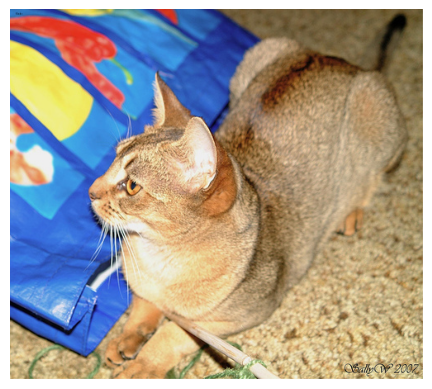

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

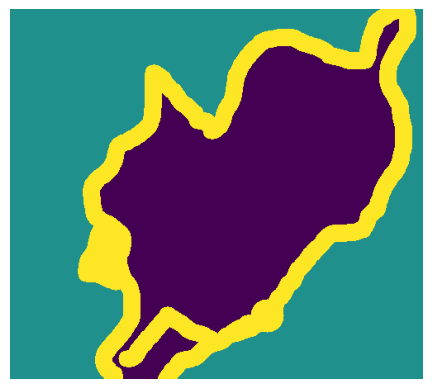

In [ ]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    # orijinal etiketler 1,2,3 değerlerinde. Bir çıkarıyoruz ve artık 0-2 arasında kalıyor.
    # 127 ile çarptığımızda da 0-254 arasında (0 siyah - 127 gri - 254 beyaza yakın) tonlar elde ediyoruz.
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) # tek bir renk kanalı kullanmak için grayscale seçiyoruz
display_target(img)


In [ ]:
import numpy as np
import random

img_size = (200, 200) # her şeyi 200x200 olarak belirliyoruz
num_imgs = len(input_img_paths) # toplam örnek sayısı

# aynı seed (1337) ile karıyoruz ki sıraları karışmasın
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale")
    )
    img = img.astype("uint8") - 1 # labellar 0 1 2 arasında olsun diye bir çıkarıyoruz
    return img

# giriş görsellerini float32, maskları uint8 ile aynı sırada alıyoruz.
# input görselleri RGB (3 renk), hedefler ise tek kanallı (integer var)
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000 # 1000 örneği validation için sakla. bölme işlemi
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs) # inputu 0-1 arasına normalize ediyor
    # downsampling
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    # upsampling
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)

    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)

    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - loss: 0.9698 - val_loss: 0.9451
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 543ms/step - loss: 0.8927 - val_loss: 0.8968
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - loss: 0.8499 - val_loss: 0.8355
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 548ms/step - loss: 0.8204 - val_loss: 0.8059
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - loss: 0.8054 - val_loss: 0.7394
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 548ms/step - loss: 0.7650 - val_loss: 0.7203
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - loss: 0.7482 - val_loss: 0.7292
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 56s 560ms/step - loss: 0.7213 - val_loss: 0.7444
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 572ms/step - loss: 0.7017 - val_loss: 0.6540
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 569ms/step - loss: 0.6823 - val_loss: 0.6562
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 570ms/step - loss: 0.6700 - val_loss: 0.8725
Epoch 12/50
100/100 ━

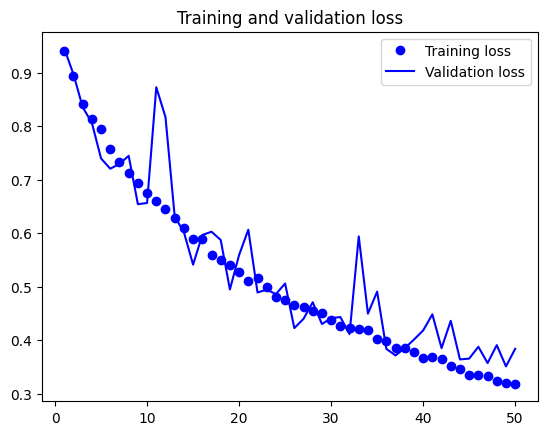

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


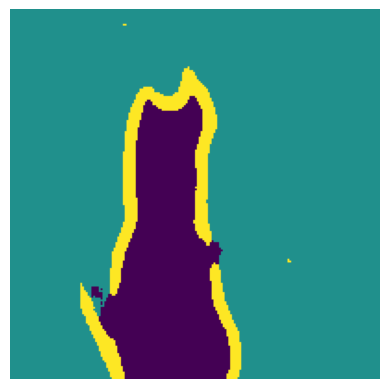

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

# Mimari

Kulaktan kulağa oynarken bilgi zaman içerisinde taşınırken bozulur, değişir. Bunlar gürültülü bir ortamda iç içe birden fazla fonksiyon ile işlem gören bilgi için de geçerlidir. Çok derin bir stack layer'ımız varsa `vanishing gradient` problemi baş gösterebilir. Bunun önüne geçmenin bir yolu da `residual connection`lar yaratmaktır.

## Residual connections
Temelde, değişmemiş giriş katmanıyla değişmiş çıkış katmanını ilişkilendirmek diyebiliriz.

Residual connection içni Pseudocode:
```pyton3
x = ...
residual = x
x = block(x)
x = add([x, residual])

```

Bu toplamada çıkışın ve girişin boyutlarının aynı olması gerekir. Fakat bu her zaman gerçekleşmeyebilir. Block fonksiyonumuz içerisinde bir conv işlemi olabilir, filtre sayısı artırılmış olabilir, max pooling uygulanmış olabilir, bunlara benzer boyutu değiştiren işlemler yapılmış olabilir.

Eğer aynı boyutta değillerse, çıkışı girişle toplayabilmek için girdiyi (residual connection) uygun boyuta lineer olarak yansıtman gerekir. Bunu yapmak için genellikle aktivasyon kullanılmayan 1x1'lik bir Conv2D katmanı kullanılır.

Ayrıca, blok içerisindeki Conv2D katmanlarında genelde padding="same" kullanılır. Böylece kenarlardan yapılan padding sonucunda oluşabilecek küçülmelerin önüne geçilmiş olur. Eğer blokta bir max pooling işlemi varsa ve bu da boyutları küçültüyorsa, bu küçülmeyi telafi etmek için residual projeksiyonuna uygun bir strides değeri verilir. Böylece, toplama işlemi sırasında her iki veri de aynı boyutta olur ve doğru şekilde birleştirilebilir.

In [ ]:
# residual block içerisinde filtre sayısı değişiyorsa

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) # downsampling'ten kaçındık
residual = layers.Conv2D(64, 1)(residual) # boyutu 32 idi, burada 1x1 Conv2D ile eşitledik
x = layers.add([x, residual])

In [ ]:
# target block içinde max pooling varsa
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual) # max pooling ile eşitlensin diye strides=2 koyduk
x = layers.add([x, residual])

In [ ]:
# genel bir örnek
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 32, 32, 3) │          0 │ input_layer_5[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │        896 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │      9,248 │ conv2d_25[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │        128 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 16, 16,    │          0 │ max_pooling2d_4[… │
│                     │ 32)               │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │     18,496 │ add_5[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │     36,928 │ conv2d_28[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 64)  │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 8, 8, 64)  │          0 │ max_pooling2d_5[… │
│                     │                   │            │ conv2d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 8, 8, 128) │      8,320 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 8, 8, 128) │          0 │ conv2d_32[0][0],  │
│                     │                   │            │ conv2d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ add_7[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,697 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

## Batch Normalization
Eğitimden önce verileri daha önce normalize etmiştir fakat her katman sonucunda çıkan sonuçlar normalize şekilde çıkmaz. Bu yöntem ile katmanların çıkışlarını normalize ediyoruz.

Eğitim sırasında: Her batch'in ortalama ve varyansına göre normalize eder.

Tahmin sırasında: Eğitimde gördüğü verilerin ortalama ve varyansının hareketli ortalama kullanır.

`normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)`


```
x = ...
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
```

In [ ]:
# batch normalizasyonunu nasıl kullanmamalısın
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)

In [ ]:
# nasıl normalizasyon kullanlır: sonrasında aktivasyon ile
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Seperable convolutions
Adından da anlaşılacağı üzere her bir kanal için ayrı bir konvolüsyon alıp bunları sonrasında birleştiriyor. Bizi 3x3 windowluk, 64 giriş, 64 çıkış kanallı bir mimarideki iş yükünden kurtarıyor.

Normal conv: 3x3x64x64

Seperable conv: 3x3x64 + 64x64

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# data augmentation yok, o yüzden hata verecek. Mimariyi anlamak için bu var.
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


Normal conv ile aldığımız test acc `83.5%` iken bu xception mimarisinde aldığımız test acc `90.8%`

# Convnetlerin ne öğrendiğinin tercüme edilmesi
Convnetler bir şeyleri öğreniyor, bir model gelişiyor fakat neyi ne kadar öğreniyor, nasıl öğreniyor bunları göremiyoruz. Yalnızca sonucu biliyoruz, "bu bir kedi ya da bu bir kedi değil". Fakat bazı yöntemler ile katmanlarda neler olduğunu görebiliyoruz:
- Orta katmanları görselleştirmek
- filtreleri görselleştirmek
- ısı haritaları (heatmap) ile sınıfların sınırlarını görmek ve doğru objeleri kapsayıp kapsamadığına bakmak.

## Visualizing intermediate activations

In [ ]:
from google.colab import files
files.upload()

Saving cats_vs_dogs_small.zip to cats_vs_dogs_small.zip
Buffered data was truncated after reaching the output size limit.

In [ ]:
!unzip -qq cats_vs_dogs_small.zip

In [ ]:
from PIL import Image
import os
import tensorflow as tf

def deep_clean_images(directory):
    for category in ["cat", "dog"]:
        folder_path = os.path.join(directory, category)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)

            # 1. Dosya uzantısı kontrolü
            if not (fname.lower().endswith(".jpg") or fname.lower().endswith(".jpeg")):
                print(f"❌ Yanlış uzantı → siliniyor: {fpath}")
                os.remove(fpath)
                continue

            # 2. PIL ile açılabiliyor mu?
            try:
                img = Image.open(fpath)
                img.verify()
            except Exception:
                print(f"❌ PIL hata → siliniyor: {fpath}")
                os.remove(fpath)
                continue

            # 3. TensorFlow ile decode edilebiliyor mu?
            try:
                img_data = tf.io.read_file(fpath)
                _ = tf.io.decode_jpeg(img_data)
            except:
                print(f"❌ TF decode error → siliniyor: {fpath}")
                os.remove(fpath)

# Uygula:
deep_clean_images("/content/cats_vs_dogs_small/train")
deep_clean_images("/content/cats_vs_dogs_small/validation")
deep_clean_images("/content/cats_vs_dogs_small/test")


❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/cat/10073.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/cat/10874.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/cat/10404.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10351.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10637.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10678.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/1017.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10353.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10173.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10383.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10726.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_small/train/dog/10733.jpg
❌ TF decode error → siliniyor: /content/cats_vs_dogs_

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs) # [0,1] aralığına aldı
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) # 180x180'dan birer piksel kırpıldı ve 178,178,32 oldu
x = layers.MaxPooling2D(pool_size=2)(x) # yarıya düştü: 89,89,32
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) # 87, 87, 64
x = layers.MaxPooling2D(pool_size=2)(x) # 43, 43, 64
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) # 41, 41, 128
x = layers.MaxPooling2D(pool_size=2)(x) # 20, 20, 128
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) # 18, 18, 256
x = layers.MaxPooling2D(pool_size=2)(x) # 9, 9, 256
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x) # 7, 7, 256
x = layers.Flatten()(x) # 12544
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification olduğu için 1
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [21]:
# image_dataset_from_directory ile resim okuma -> görselleri tensörlere çeviriyor
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 1986 files belonging to 2 classes.
Found 991 files belonging to 2 classes.
Found 1987 files belonging to 2 classes.


In [22]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

# data batch shape: (32, 180, 180, 3)
# labels batch shape: (32, )

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [23]:
# training the regularized convnet
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.5223 - loss: 0.7024 - val_accuracy: 0.6034 - val_loss: 0.6876
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5513 - loss: 0.6937 - val_accuracy: 0.4985 - val_loss: 0.7255
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5881 - loss: 0.6691 - val_accuracy: 0.5096 - val_loss: 0.6847
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6459 - loss: 0.6331 - val_accuracy: 0.5954 - val_loss: 0.6657
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.6653 - loss: 0.6151 - val_accuracy: 0.5409 - val_loss: 0.7978
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6724 - loss: 0.6030 - val_accuracy: 0.5419 - val_loss: 0.9210
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6964 - loss: 0.5914 - val_accuracy: 0.6852 - val_loss: 0.6060
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.7182 - loss: 0.5433 - val_accuracy: 

In [24]:
from tensorflow import keras
model = keras.models.load_model(
"convnet_from_scratch_with_augmentation.keras")

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

In [25]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
         img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array
img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


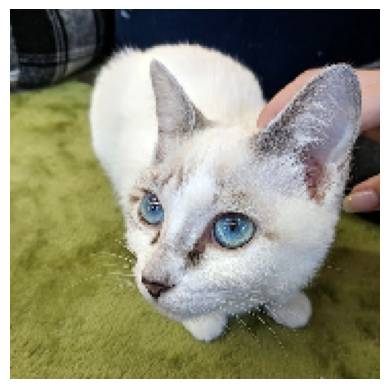

In [26]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [27]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)


In [28]:
activations = activation_model.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [30]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


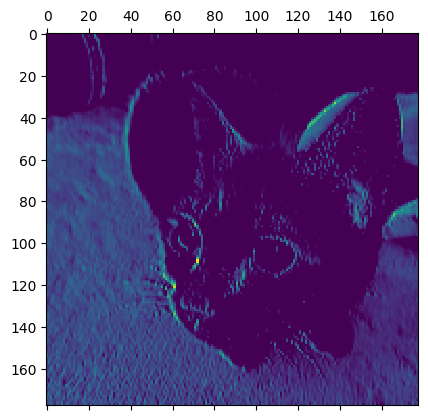

In [31]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

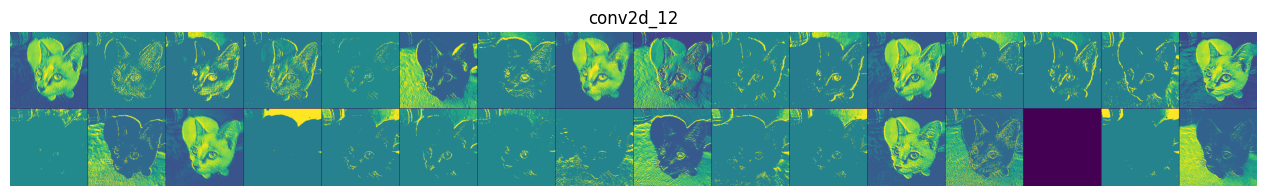

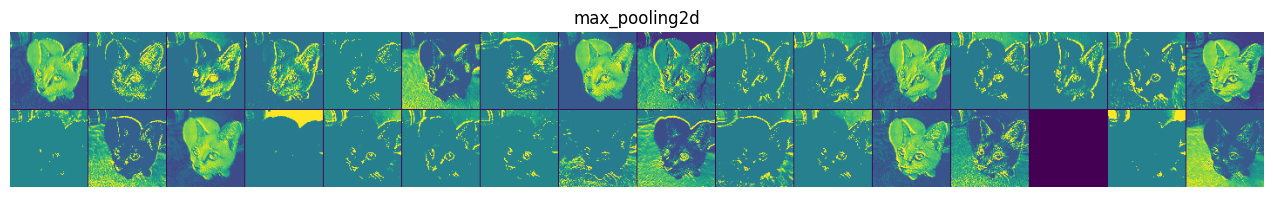

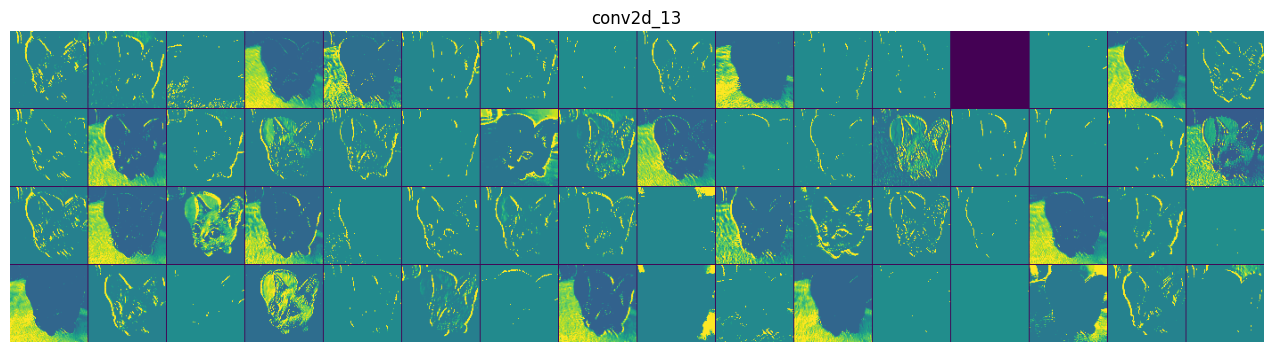

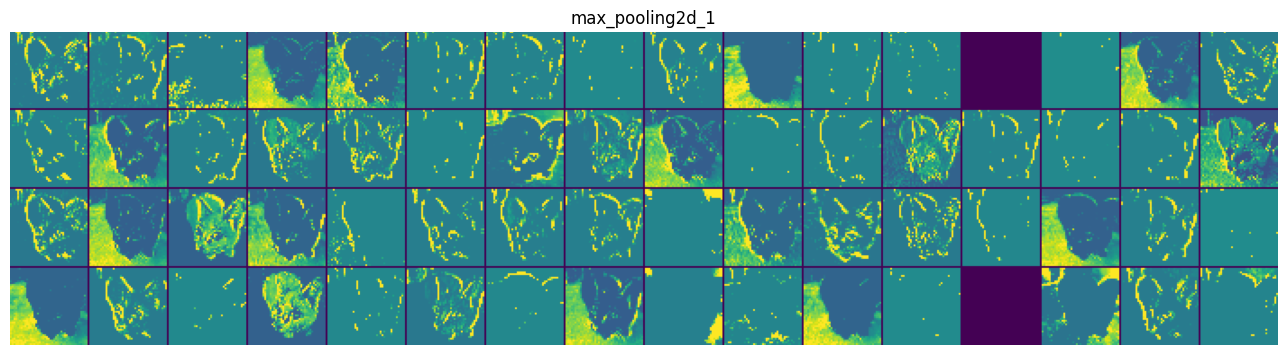

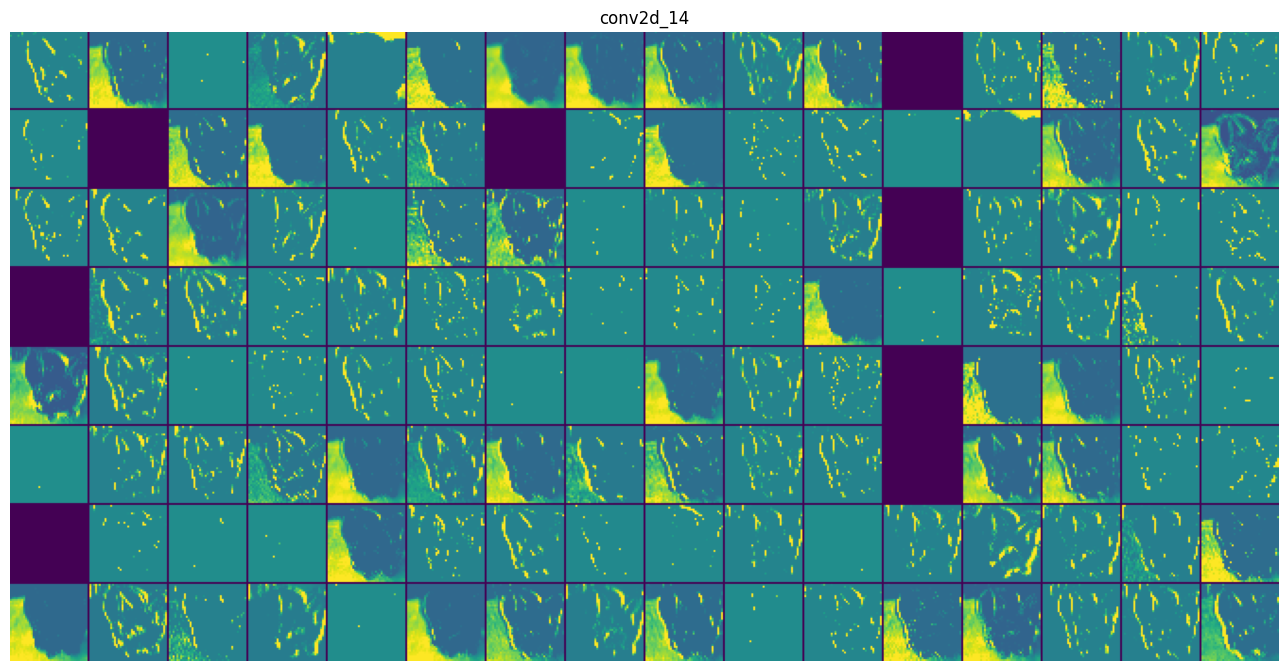

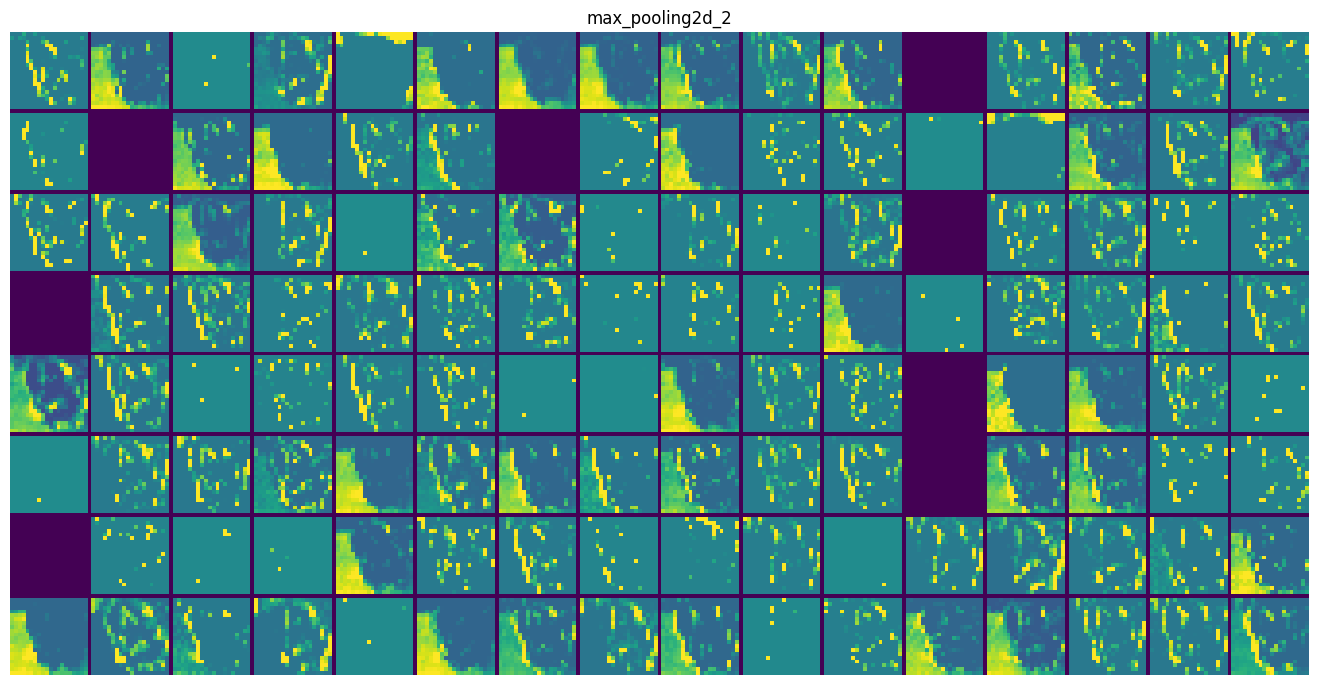

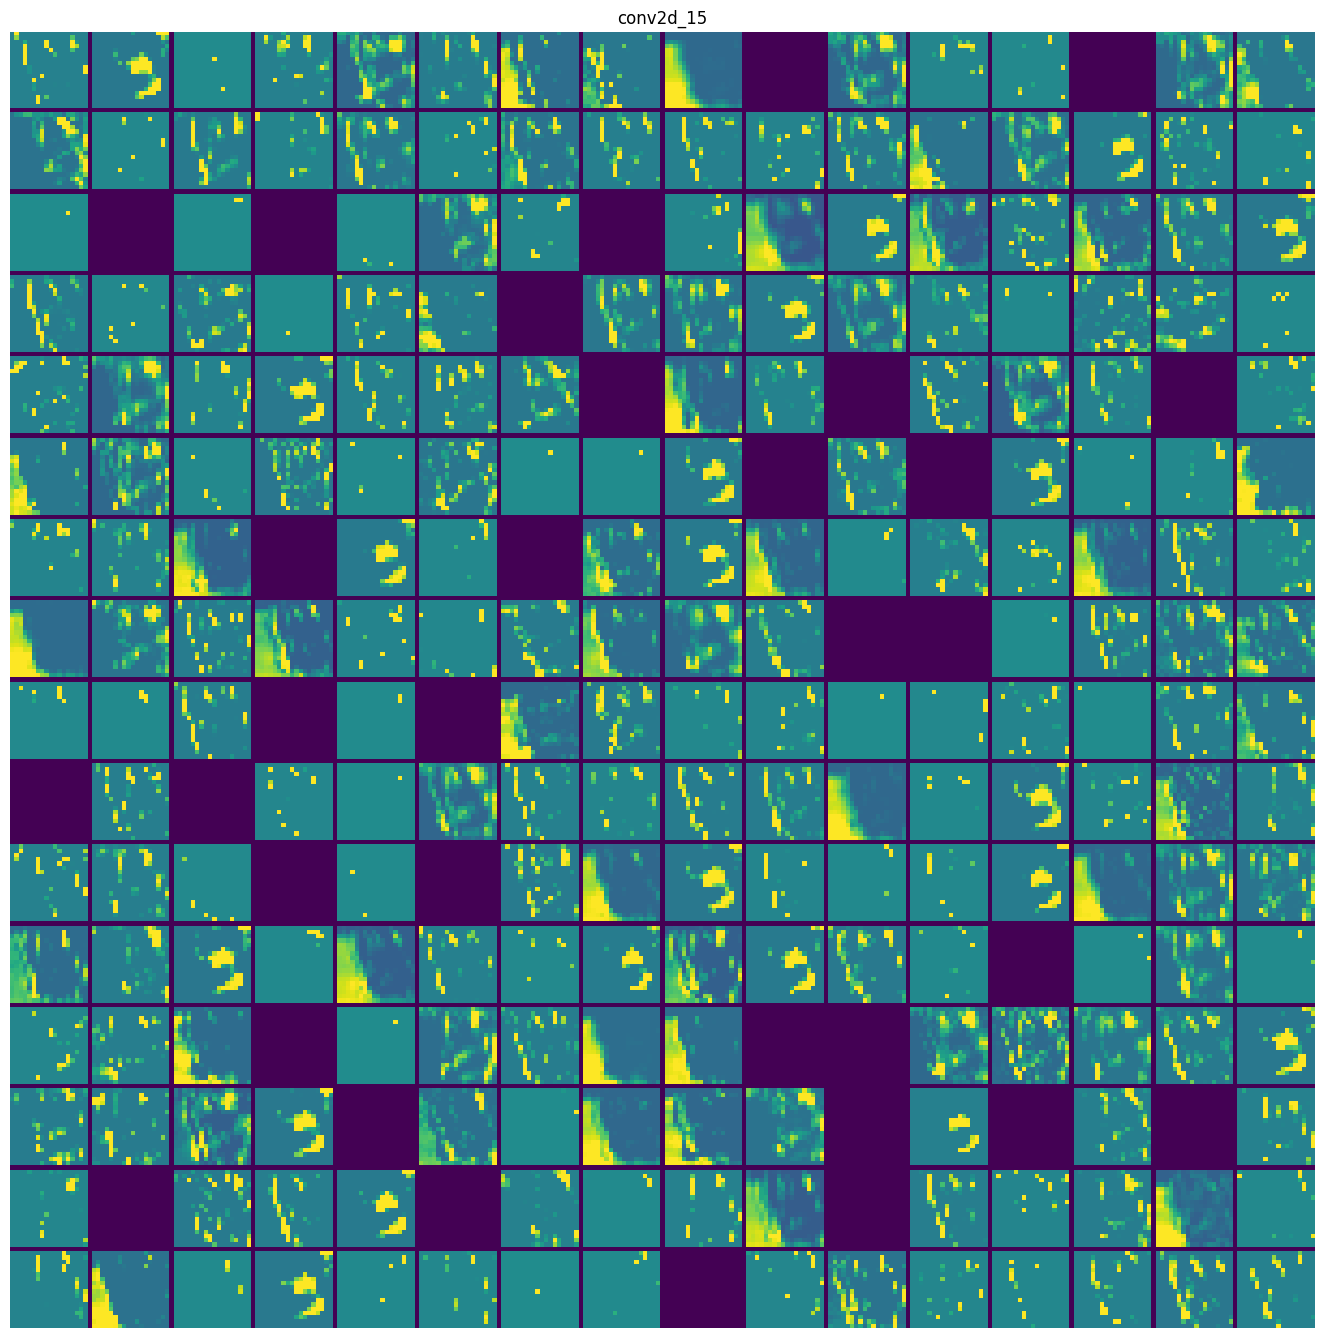

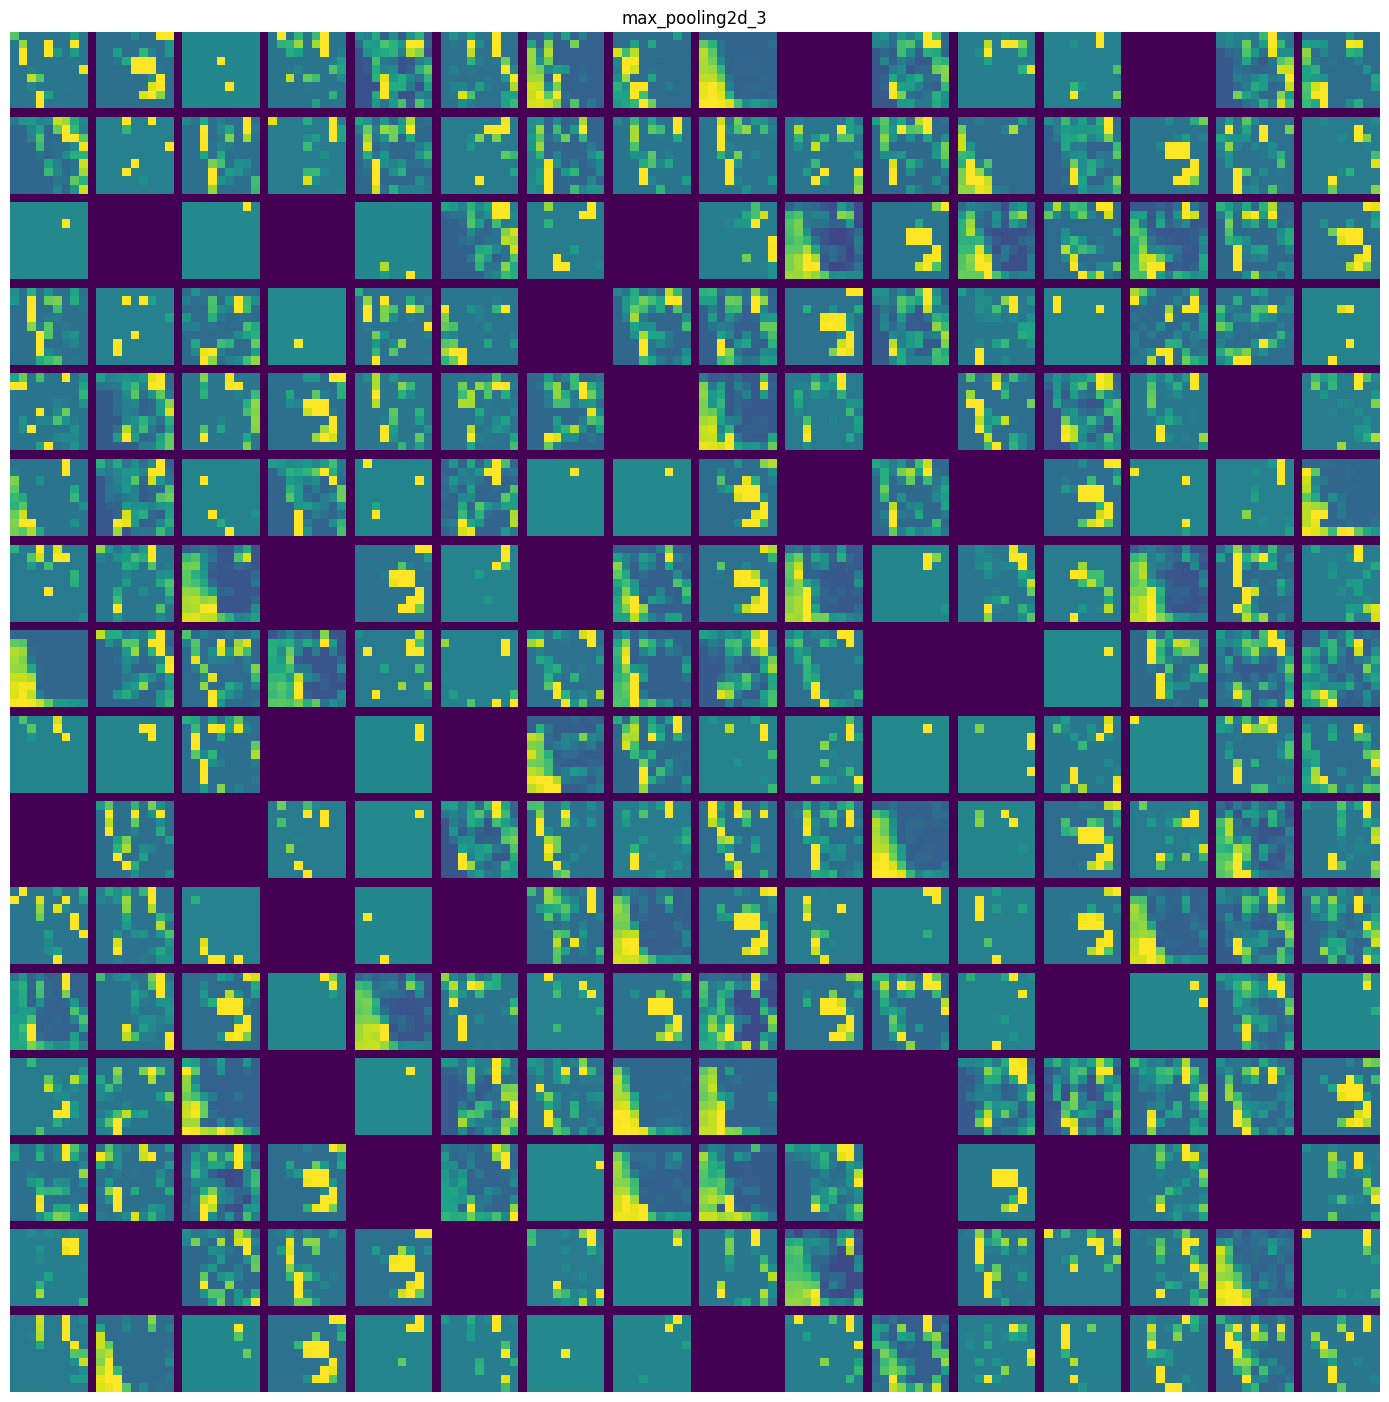

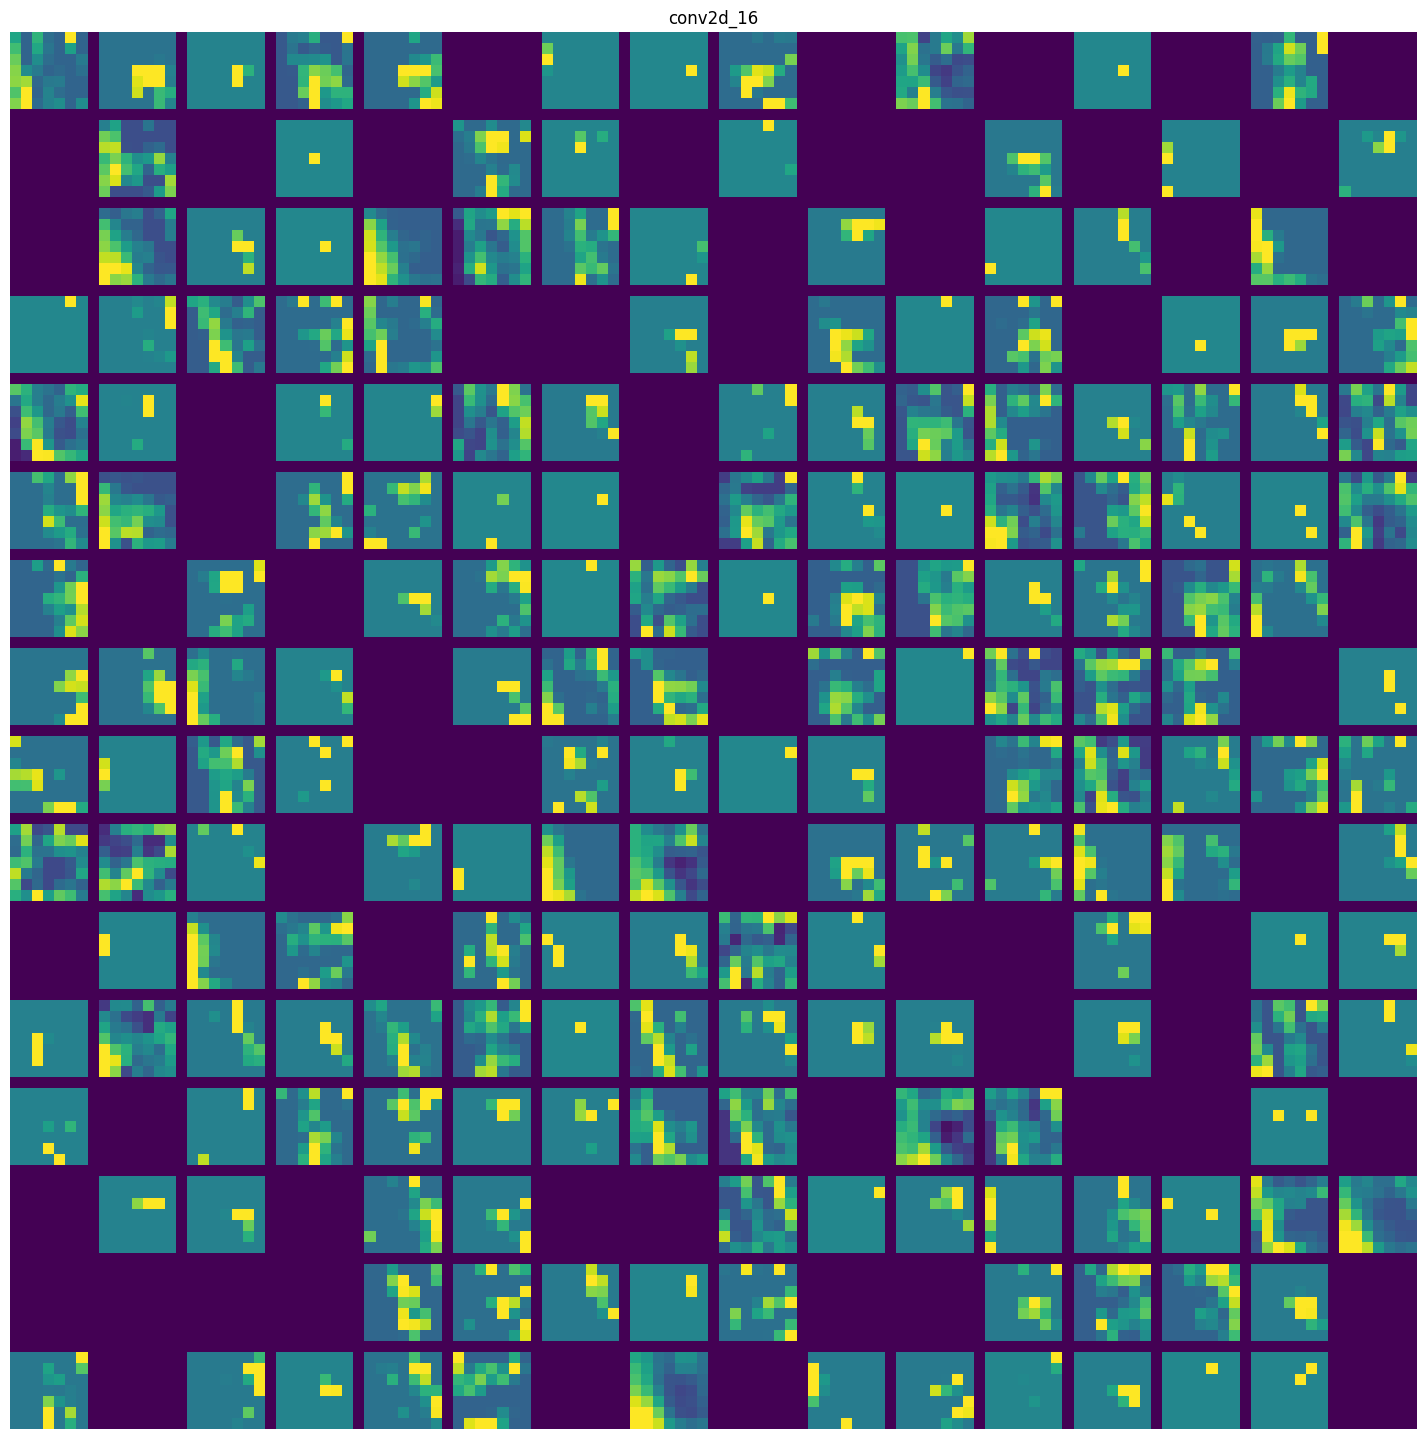

In [32]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((
        (size + 1) * n_cols - 1,
        images_per_row * (size + 1) - 1
    ))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")
                display_grid[
                    col * (size + 1): (col + 1) * size + col,
                    row * (size + 1): (row + 1) * size + row
                ] = channel_image

    scale = 1. / size
    plt.figure(figsize=(
        scale * display_grid.shape[1],
        scale * display_grid.shape[0]
    ))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")


## Visualizing convnet filters

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


# instantiating the xception conv base
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

In [ ]:
# katmanların isimleri

for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_8
block3_sepconv1
block3_sepconv2
conv2d_9
block4_sepconv1
block4_sepconv2
conv2d_10
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_11
block14_sepconv1
block14_sepconv2


In [ ]:
# creating a feature extractor model

layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [33]:
# using the feature extractor
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_264']
Received: inputs=Tensor(shape=(1, 180, 180, 3))
  warnings.warn(msg)


In [34]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [35]:
# loss maximization via stochastic gradient ascent
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
        grads = tape.gradient(loss, image)
        grads = tf.math.l2_normalize(grads)
        image += learning_rate * grads
    return image


In [36]:
# Function to generate filter visualizations
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.0
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3)
    )
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()


In [37]:
# Utility function to convert a tensor into a valid image
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

# plt.axis("off")
# plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [38]:
# Generating a grid of all filter response patterns in a layer
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        row_start = (cropped_width + margin) * i
        row_end = (cropped_width + margin) * i + cropped_width
        column_start = (cropped_height + margin) * j
        column_end = (cropped_height + margin) * j + cropped_height
        stitched_filters[
            row_start: row_end,
            column_start: column_end, :] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)


Processing filter 0


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_264']
Received: inputs=Tensor(shape=(1, 200, 200, 3))
  warnings.warn(msg)


Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Processing filter 48
P

## Visualizing heatmaps of class activation

In [39]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [40]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))


733657/733657 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[('n02504458', 'African_elephant', np.float32(0.86993945)), ('n01871265', 'tusker', np.float32(0.076956354)), ('n02504013', 'Indian_elephant', np.float32(0.023541784))]


In [42]:
np.argmax(preds[0])

np.int64(386)

In [43]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)


In [44]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)


In [45]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    grads = tape.gradient(top_class_channel, last_conv_layer_output)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_433']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


In [46]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)


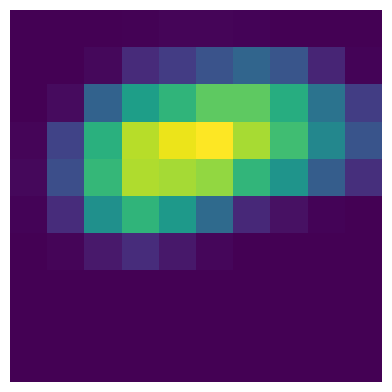

In [47]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.axis('off')
plt.show()


In [48]:
import matplotlib.cm as cm
from tensorflow import keras
import numpy as np

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)


/tmp/ipython-input-48-2016696419.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


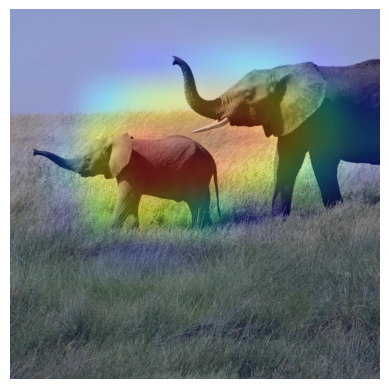

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("elephant_cam.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()
